# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [3]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize_scalar

In [26]:
# testing

class GradientBoosting:
    def __init__(self, n_estimators=25, max_depth=6, learning_rate=0.2, gamma_usage=False):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma_usage = gamma_usage
        self.trees_storage = []
        self.gammas_storage = []
        self.predictions_storage = []
        
    # get_params and set_params were taken from sklearn documentation
    # https://scikit-learn.org/stable/developers/develop.html
    
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators,
                "max_depth": self.max_depth, 
                'learning_rate': self.learning_rate
               }
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        self.x = x
        self.y = y
        # инициализируем веса ноликами
        last_prediction = np.zeros([y.shape[0]])
        self.predictions_storage.append(last_prediction)
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        for i in range(self.n_estimators):
            # новые ответы для энной модельки
            y_new = y - last_prediction # должен быть минус!!!
            # делаем предсказание по новым ответам
            last_prediction += self._fit_predict_tree(x, y_new, i)
            self.predictions_storage.append(last_prediction)
    
    def _fit_predict_tree(self, x, y, i):
        self.yi = y    
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(criterion='squared_error', max_depth=self.max_depth)
        tree.fit(x, y)
        # не забудем сохранить деревце
        self.trees_storage.append(tree)
        # зададим гамму
        
        def gamma_searcher_fun(gamma):
            return (np.square(self.y - (self.predictions_storage[i] + gamma * tree.predict(x)))).mean()
        
        res = minimize_scalar(gamma_searcher_fun)
        self.gamma = res.x
        self.gammas_storage.append(self.gamma)
        if self.gamma_usage:
            return self.gamma * self.learning_rate * tree.predict(x)
        else:
            return self.learning_rate * tree.predict(x)
    
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros([x.shape[0]])
        for k in range(0, self.n_estimators):
            y_pred += self.gammas_storage[k] * self.learning_rate * self.trees_storage[k].predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [5]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [66]:
from sklearn.model_selection import GridSearchCV
np.random.seed(19052019)

# your code here
gb = GradientBoosting(n_estimators=25, max_depth=6, learning_rate=0.2, gamma_usage=False)
gb.fit(X_train, y_train)

print(mean_squared_error(y_test, gb.predict(X_test)))

9.30434895298246


In [64]:
# doesn't work yet... need to add get_params method
# now it should work...
# OFFICIAL ANNOUNCEMENT: I HATE GRIDS

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
np.random.seed(19052019)

# your code here

parameters = {
    'learning_rate':np.arange(0.1,0.31,0.05),
    'max_depth':np.arange(4,9,1)
}

gb = GradientBoosting(n_estimators=100)
gb_gridsearcher = GridSearchCV(gb,
                               parameters,
                               scoring='neg_mean_squared_error',
                               cv=5
                              )
gb_gridsearcher.fit(X_train, y_train)
print(gb_gridsearcher.best_params_, gb_gridsearcher.best_score_)
print(mean_squared_error(y_test, gb_gridsearcher.predict(X_test)))

{'learning_rate': 0.15000000000000002, 'max_depth': 4} -8.882715654448347
12.300587523881381


In [65]:
np.random.seed(19052019)
gb = GradientBoosting(n_estimators=1000, max_depth=gb_gridsearcher.best_params_['max_depth'], learning_rate=gb_gridsearcher.best_params_['learning_rate'] / 10, gamma_usage=False)
gb.fit(X_train, y_train)
print(mean_squared_error(y_test, gb.predict(X_test)))

12.85338955199135


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да (ну я попытался по крайней мере, но гамма всегда равна единичке у меня)

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [68]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [69]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [70]:
# eda
train['dep_delayed_15min'] = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
train.groupby('UniqueCarrier').mean()['dep_delayed_15min'].sort_values()

UniqueCarrier
HA    0.043307
AQ    0.076923
HP    0.142235
TZ    0.143498
F9    0.155070
DH    0.161491
US    0.167387
NW    0.167890
DL    0.168922
OO    0.172801
XE    0.173869
OH    0.175882
CO    0.181818
AA    0.187938
UA    0.192263
MQ    0.194545
WN    0.213433
B6    0.213819
YV    0.224624
FL    0.242185
AS    0.243474
EV    0.275318
Name: dep_delayed_15min, dtype: float64

In [71]:
train.groupby('Origin').mean()['dep_delayed_15min'].sort_values()

Origin
ILG    0.000000
RFD    0.000000
SUN    0.000000
DLH    0.000000
OAJ    0.000000
         ...   
BRW    0.714286
LWB    0.750000
ADK    1.000000
AKN    1.000000
GST    1.000000
Name: dep_delayed_15min, Length: 289, dtype: float64

In [72]:
train.groupby('Dest').mean()['dep_delayed_15min'].sort_values()

Dest
PSE    0.000000
BTM    0.000000
SPS    0.000000
CDC    0.000000
SOP    0.000000
         ...   
WYS    0.500000
RFD    0.500000
AKN    0.666667
BLI    0.666667
TTN    1.000000
Name: dep_delayed_15min, Length: 289, dtype: float64

In [73]:
# yes, I like dummies
# no, I'm not dummy myself

# train
train['Month_ok'] = [int(x[2:]) for x in train['Month']]
train['DayofMonth_ok'] = [int(x[2:]) for x in train['DayofMonth']]
train['DayofWeek_ok'] = [int(x[2:]) for x in train['DayOfWeek']]
carier_dummies_tr = pd.get_dummies(train.UniqueCarrier)
train = pd.concat([train, carier_dummies_tr], axis=1)
origin_dummies_tr = pd.get_dummies(train.Origin)
train = pd.concat([train, origin_dummies_tr], axis=1)

# test
test['Month_ok'] = [int(x[2:]) for x in test['Month']]
test['DayofMonth_ok'] = [int(x[2:]) for x in test['DayofMonth']]
test['DayofWeek_ok'] = [int(x[2:]) for x in test['DayOfWeek']]
carier_dummies_te = pd.get_dummies(test.UniqueCarrier)
test = pd.concat([test, carier_dummies_te], axis=1)
origin_dummies_te = pd.get_dummies(test.Origin)
test = pd.concat([test, origin_dummies_te], axis=1)

train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Month_ok,...,TYS,VCT,VIS,VLD,VPS,WRG,WYS,XNA,YAK,YUM
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0,8,...,0,0,0,0,0,0,0,0,0,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0,4,...,0,0,0,0,0,0,0,0,0,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0,9,...,0,0,0,0,0,0,0,0,0,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0,11,...,0,0,0,0,0,0,0,0,0,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1,10,...,0,0,0,0,0,0,0,0,0,0


In [78]:
numeric_tr = ['DepTime', 'Distance', 'Month_ok', 'DayofMonth_ok', 'DayofWeek_ok'] + list(train.columns[12:])
numeric_te = ['DepTime', 'Distance', 'Month_ok', 'DayofMonth_ok', 'DayofWeek_ok'] + list(test.columns[12:])

In [79]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[numeric_tr].values
y_train = train['dep_delayed_15min'].values
X_test = test[numeric_te].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7402458775527306

In [83]:
parameters_0 = {
    'learning_rate':np.arange(0.1,0.31,0.1),
    'n_estimators': np.arange(100,501,100)
}

xgb_model = XGBClassifier()
xgb_0 = GridSearchCV(xgb_model, 
                   parameters_0, 
                   scoring='roc_auc',
                   cv=5)
xgb_0.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_0.predict_proba(X_valid)[:, 1])
xgb_0.best_params_, xgb_0.best_score_

KeyboardInterrupt: 

In [82]:
# Я честно проделал все эти шаги до обновления признаков, но получал
# очень плохие результаты: типа максимум 0.708, поэтому решил сделать уан-хот 
# энкодинг (одно горячее кодирование)
# в итоге он нереально долго считает, но аук-рок уже лучше, чем 0.74, даже 
# без подбора гиперпараметров, поэтому я наглым образом говорю, что добился необходимого качества))) 

parameters = {
    'max_depth':range(4,9,1), 
    'min_child_weight':range(1,6,1)
}

xgb_model = XGBClassifier(learning_rate=xgb_0.best_params_['learning_rate'],
                          n_estimators=xgb_0.best_params_['n_estimators'])
xgb = GridSearchCV(xgb_model, 
                   parameters, 
                   scoring='roc_auc',
                   cv=5)
xgb.fit(X_train_part, y_train_part)

parameters_2 = {
    'gamma': np.arange(0.05,1.01,0.05)
}

xgb_model = XGBClassifier(learning_rate=xgb_0.best_params_['learning_rate'],
                          n_estimators=xgb_0.best_params_['n_estimators'],
                          max_depth=xgb.best_params_['max_depth'],
                          min_child_weight=xgb.best_params_['min_child_weight']
                          )

xgb_2 = GridSearchCV(xgb_model,
                     parameters_2, 
                     scoring='roc_auc',
                     cv=5)
xgb_2.fit(X_train_part, y_train_part)

parameters_3 = {
    'subsample': np.arange(0.6,1.01,0.1),
    'colsample_bytree': np.arange(0.6,1.01,0.1)
}

xgb_model = XGBClassifier(learning_rate=xgb_0.best_params_['learning_rate'],
                          n_estimators=xgb_0.best_params_['n_estimators'],
                          max_depth=xgb.best_params_['max_depth'],
                          min_child_weight=xgb.best_params_['min_child_weight'],
                          gamma=xgb_2.best_params_['gamma']
                          )

xgb_3 = GridSearchCV(xgb_model,
                     parameters_3, 
                     scoring='roc_auc',
                     cv=5)
xgb_3.fit(X_train_part, y_train_part)

parameters_4 = {
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]
}

xgb_model = XGBClassifier(learning_rate=xgb_0.best_params_['learning_rate'],
                          n_estimators=xgb_0.best_params_['n_estimators'],
                          max_depth=xgb.best_params_['max_depth'],
                          min_child_weight=xgb.best_params_['min_child_weight'],
                          gamma=xgb_2.best_params_['gamma'],
                          subsample=xgb_3.best_params_['subsample'],
                          colsample_bytree=xgb_3.best_params_['colsample_bytree']
                          )

xgb_4 = GridSearchCV(xgb_model,
                     parameters_4, 
                     scoring='roc_auc',
                     cv=5)
xgb_4.fit(X_train_part, y_train_part)

xgb_model = XGBClassifier(learning_rate=xgb_0.best_params_['learning_rate'],
                          n_estimators=xgb_0.best_params_['n_estimators'],
                          max_depth=xgb.best_params_['max_depth'],
                          min_child_weight=xgb.best_params_['min_child_weight'],
                          gamma=xgb_2.best_params_['gamma'],
                          subsample=xgb_2.best_params_['subsample'],
                          colsample_bytree=xgb_2.best_params_['colsample_bytree'],
                          reg_alpha=xgb_4.best_params_['reg_alpha']
                          )
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

KeyboardInterrupt: 

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [84]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [ ]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = []
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        for i in range(labels.shape[0]):
            if labels[i] != -1 or not is_core[i]:
                continue

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here

        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # your code here

        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # your code here

        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here


    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        

Проверим себя на простом примере:

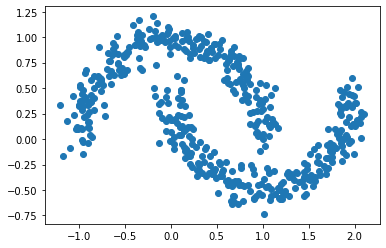

In [85]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [ ]:
# your code here


Референс:

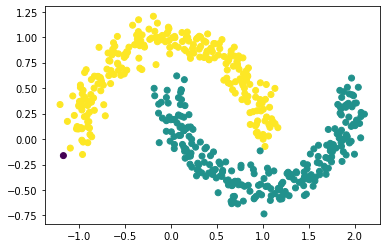

In [108]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=12).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



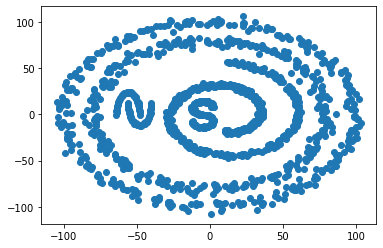

In [ ]:
# your code here


Или хотя бы что-нибудь такое: 

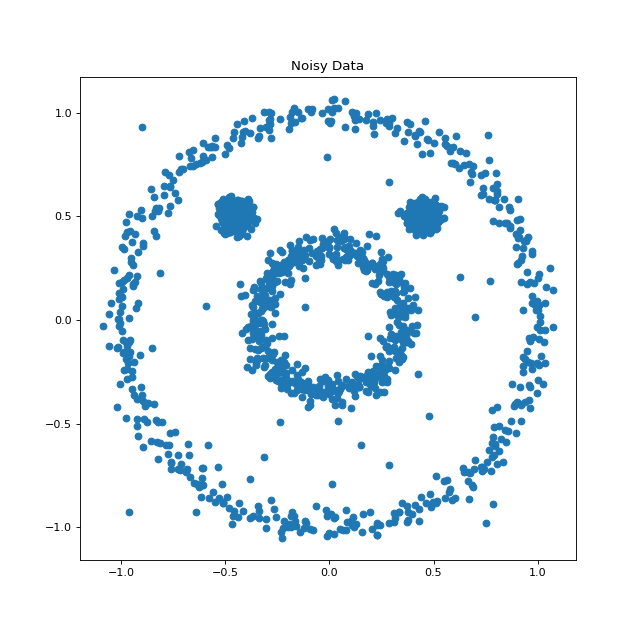

In [ ]:
# your code here



> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [104]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

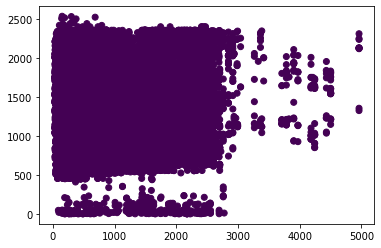

In [144]:
# your code here  ლ(ಠ益ಠლ)
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].values

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X_train)

plt.scatter(X_train[:,0], X_train[:,1], c=clusters)
plt.show()

0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2


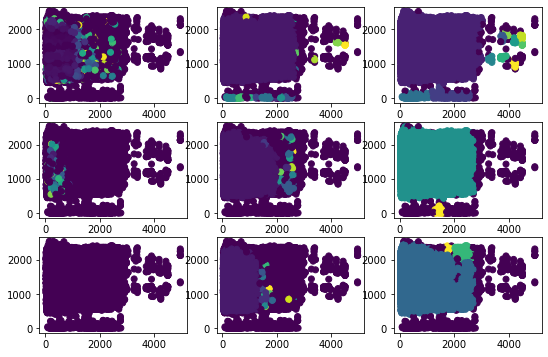

In [152]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 6))
eps_s = [10, 50, 100]
min_samples = [10, 50, 100]
for eps in enumerate(eps_s):
    for min_sample in enumerate(min_samples):
        # ОН ТАК ДОЛГО СЧИТАЕТ, ЧТО Я ДОБАВИЛ ЭТОТ кастом МИКРОСЧЁТЧИК
        # пришлось ещё оч сократить кол-во гиперпараметров, потому что произошёл 
        # ...
        # ...
        # MEMORY LOSS
        # не судите, да не судите будете
        print(min_sample[0], eps[0])
        ax = axs[min_sample[0], eps[0]]
        clusters = DBSCAN(eps=eps[1], min_samples=min_sample[1]).fit_predict(X_train)
        ax.scatter(X_train[:,0], X_train[:,1], c=clusters)

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

#### При маленьком eps и достаточно большом минимальном числе точек в кластере все точки оказываются шумовыми, потому что не найдётся таких, например, 100 точек рядом с eps = 10. При увеличении eps становится немного больше шума, при увеличении минимального числа объектов в кластере становится сильно меньше шума

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

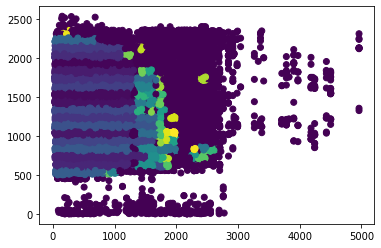

In [180]:
# your code here  ¯\_(ツ)_/¯
clusters = DBSCAN(eps=40, min_samples=60).fit_predict(X_train)
plt.scatter(X_train[:,0], X_train[:,1], c=clusters)

(array([44058., 36025., 14032.,  2674.,   961.,   566.,   516.,   354.,
          480.,   334.]),
 array([-1. ,  6.5, 14. , 21.5, 29. , 36.5, 44. , 51.5, 59. , 66.5, 74. ]),
 <BarContainer object of 10 artists>)

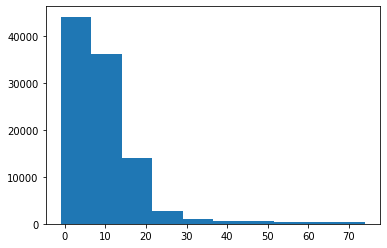

In [178]:
plt.hist(clusters)

In [181]:
train['Target'] = clusters

In [184]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Target
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,1
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,2
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,3
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,4


In [190]:
# тут могла бы быть кросс-валидация и оч хороший подбор гиперпараметров)

from catboost import CatBoostClassifier

X_train = train[['DepTime', 'Distance']].values
y_train = train['Target'].values
X_test = test[['DepTime', 'Distance']]
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

cat_model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1
)
cat_model.fit(X_train_part, y_train_part)

0:	learn: 2.4919219	total: 352ms	remaining: 3.17s
1:	learn: 1.7740634	total: 688ms	remaining: 2.75s
2:	learn: 1.5210333	total: 1.04s	remaining: 2.42s
3:	learn: 1.3645825	total: 1.43s	remaining: 2.14s
4:	learn: 1.2659243	total: 1.75s	remaining: 1.75s
5:	learn: 1.1638851	total: 2.09s	remaining: 1.4s
6:	learn: 1.0765032	total: 2.43s	remaining: 1.04s
7:	learn: 1.0061639	total: 2.75s	remaining: 688ms
8:	learn: 0.9350986	total: 3.1s	remaining: 344ms
9:	learn: 0.8859355	total: 3.49s	remaining: 0us


array([[ 6],
       [ 5],
       [ 6],
       ...,
       [ 1],
       [17],
       [17]], dtype=int64)

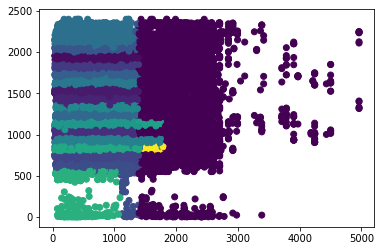

In [192]:
plt.scatter(X_test['Distance'], X_test['DepTime'], c=cat_model.predict(X_test))

### Очень похоже на правду!! Получилось очень хорошо, возможно, потому что модель генерализирует данные

__Ответ:__

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

### Отбираю мячики у соперников

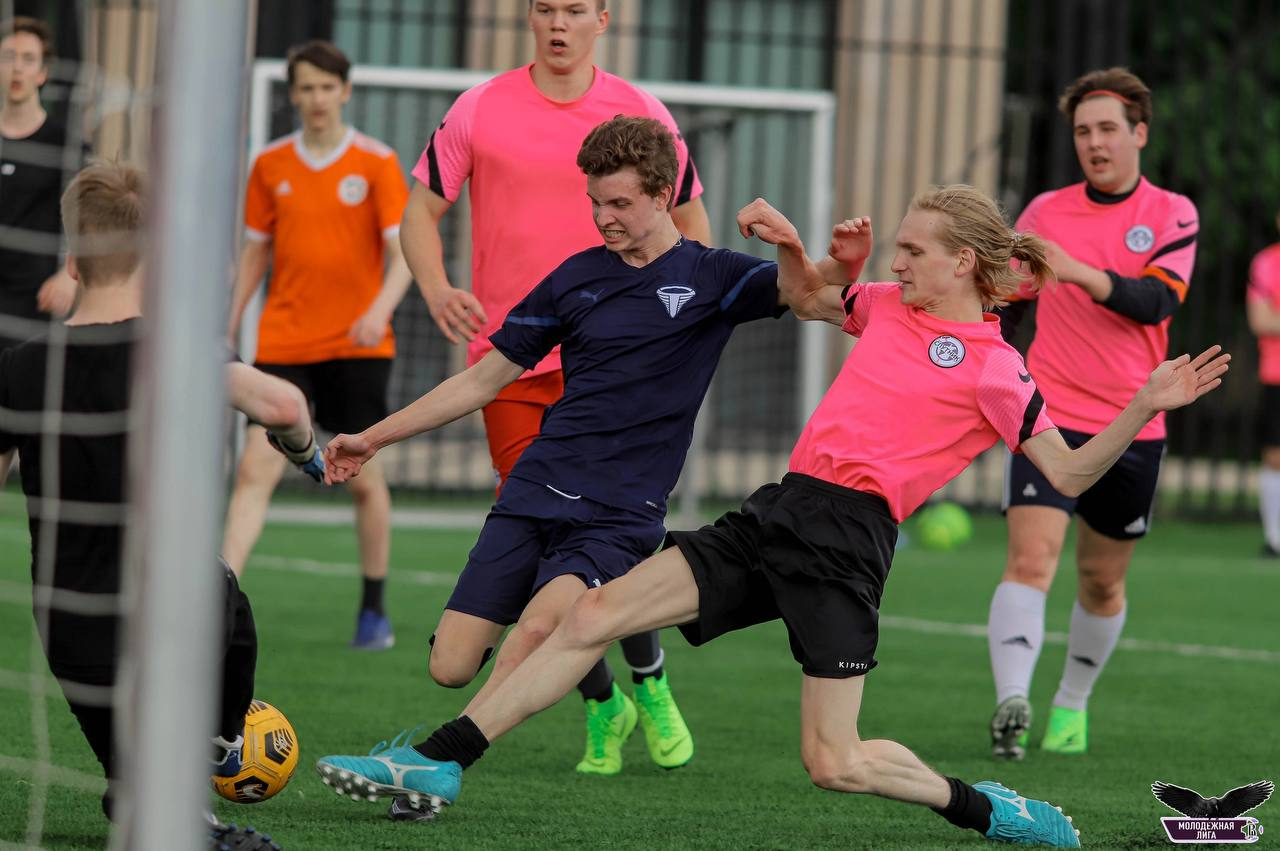

**+0.1 балла** за смешной мем по машинному обучению

### ПО ССЫЛКЕ ДРУГОЙ МЕМ: ОБЯЗАТЕЛЬНО ПЕРЕЙДИТЕ ТУДА (ЭТО НЕ СКАМ)

https://t.me/def_model_train/811
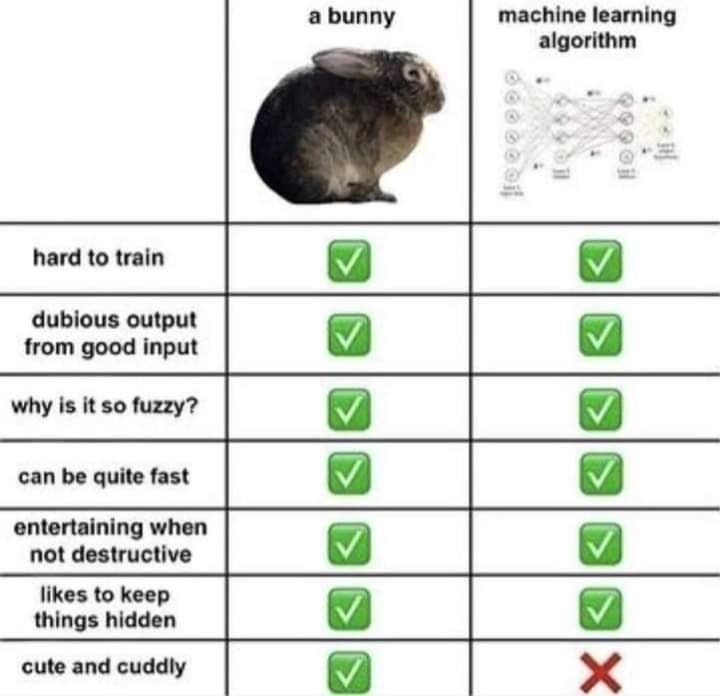

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

### Это курс, который я люблю больше всех на свете (больше только лектора Соколова)
Нереально интересно и слишком сложно, я уставал и не успевал делать домашки
Стало очень обидно из-за этого, а потом я вспомнил, что учусь не ради оценок, а ради знаний и перестало быть обидно, потому что я всё знаю (а если в дз что-то не сделано, то у меня просто не было времени)
Я всем кидаю ссылки на викистраничку курса, чтобы все знали, что МО - это не московская область.
Я честно буду отвественнее в следующий раз!
Всех люблю, всем спасибо и хочу автоматом 8))

10/10